# Born to slide: mobile origin licensing factors confer resistance to conflicts with RNA polymerase

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ S4F
+ S4J
+ S4L
+ S4M

#### Archives:
+ Transcription_low-chromatin-DNA.yama
+ Transcription_high-chromatin-DNA.yama
+ Transcription_naked-DNA_ATP_LD555.yama
+ Transcription_naked-DNA_ATPgS_LD555.yama
+ Transcription_naked-DNA_ATP_LD655.yama
+ Transcription_naked-DNA_ATP_AF488.yama
+ Transcription_ORC-DNA_ATP.yama
+ Transcription_naked-DNA_T7T_ATP.yama
+ Transcription_ORC-DNA_T7T_ATP.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from scipy.stats import norm
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_low-chromatin-DNA.yama',
                     'Transcription_high-chromatin-DNA.yama',
                     'Transcription_naked-DNA_ATP_LD555.yama',
                     'Transcription_naked-DNA_ATPgS_LD555.yama',
                     'Transcription_naked-DNA_ATP_LD655.yama',
                     'Transcription_naked-DNA_ATP_AF488.yama',
                     'Transcription_ORC-DNA_ATP.yama',
                     'Transcription_naked-DNA_T7T_ATP.yama',
                     'Transcription_ORC-DNA_T7T_ATP.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure4/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure4/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_low-chromatin-DNA,3,470,LD555-H3-NUC; ybbR-LD655-T7,ATP,False,50x,False,passed
Transcription_high-chromatin-DNA,1,180,LD555-H3-NUC; ybbR-LD655-T7,ATP,False,75x,False,passed
Transcription_naked-DNA_ATP_LD555,6,303,ybbR-LD555-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_ATPgS_LD555,3,224,ybbR-LD555-T7,ATPgS,False,n/a,False,passed
Transcription_naked-DNA_ATP_LD655,1,281,ybbR-LD655-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_ATP_AF488,1,129,SNAP-AF488-T7,ATP,False,n/a,False,passed
Transcription_ORC-DNA_ATP,1,206,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_T7T_ATP,1,325,ybbR-LD655-T7,ATP,False,n/a,True,passed
Transcription_ORC-DNA_T7T_ATP,3,612,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,True,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(NUC_1_, initial_intensity, ), (NUC_1_, lifetime, ), (NUC_1_, number_pauses, ), (NUC_1_, start_site, ), (NUC_1_, stop_site, ), (NUC_2_, initial_intensity, ), (NUC_2_, lifetime, ), (NUC_2_, number_pauses, ), (NUC_2_, start_site, ), (NUC_2_, stop_site, ), (NUC_3_, initial_intensity, ), (NUC_3_, lifetime, ), (NUC_3_, number_pauses, ), (NUC_3_, start_site, ), (NUC_3_, stop_site, ), (NUC_4_, initial_intensity, ), (NUC_4_, lifetime, ), (NUC_4_, number_pauses, ), (NUC_4_, start_site, ), (NUC_4_, stop_site, ), (NUC_5_, initial_intensity, ), (NUC_5_, lifetime, ), (NUC_5_, number_pauses, ), (NUC_5_, start_site, ), (NUC_5_, stop_site, ), (NUC_6_, initial_intensity, ), (NUC_6_, lifetime, ), (NUC_6_, number_pauses, ), (NUC_6_, start_site, ), (NUC_6_, stop_site, ), (ORC_1_, initial_intensity, ), (ORC_1_, lifetime, ), (ORC_1_, number_pauses, ), (ORC_1_, start_site, ), (ORC_1_, stop_site, ), (ORC_2_, initial_intensity, ), (ORC_2_, lifetime, ), (ORC_2_, number_pauses, ), (ORC_2_, start_site, ), (ORC_2_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

[0 rows x 45 columns]

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'t7_terminator'] = archive.t7_terminator
        df.loc[molecule.uid,'chromatin'] = archive.chromatin
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:10][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            else:
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()

            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")
                    
# fill all NaN values in number_protein with 0
proteins = set()
for archive in DnaMoleculeArchive.instances:
    proteins.update(archive.proteins)

for protein in proteins:
    df['number_'+protein] = df['number_'+protein].apply(lambda value: 0 if np.isnan(value) else value)
    
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                          NUC_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
oumBTp4C7jaaCrUonxFBfz          50602.75    150.0           NaN      NaN   
tBFZqXqxoeQGSB67GRfaGb          49971.50     80.0           0.0      NaN   
kAfDXrSuUFGknUjZV36oa7          42583.80    150.0           NaN      NaN   
8hqAtVir9BRdkggTDzH5rR          31860.50     34.0           NaN      NaN   
qGG7u2416k1edXZycFfp96          78182.45     32.0           NaN      NaN   

molecule                                                                  \
properties                                       pause_2                   
properties_details     position_on_dna recovery duration position_on_dna   
oumBTp4C7jaaCrUonxFBfz             NaN      NaN      NaN             NaN   
tBFZqXqxoeQGSB67GRfaGb             NaN      NaN      NaN             NaN   
kAfDXrSuUFGknUjZV36oa7             NaN      NaN      NaN             NaN   
8hqAtVir9BRdkggTDzH5rR             NaN      NaN      NaN             NaN   
qGG7u2416k1edXZycFfp96             NaN      NaN      NaN             NaN   

molecule                                       ...    label_T7 nucleotide  \
properties                         start_site  ...                          
properties_details     recovery                ...                          
oumBTp4C7jaaCrUonxFBfz      NaN   2706.691854  ...  ybbR-LD655        ATP   
tBFZqXqxoeQGSB67GRfaGb      NaN  15625.001240  ...  ybbR-LD655        ATP   
kAfDXrSuUFGknUjZV36oa7      NaN   1151.118076  ...  ybbR-LD655        ATP   
8hqAtVir9BRdkggTDzH5rR      NaN   9588.400447  ...  ybbR-LD655        ATP   
qGG7u2416k1edXZycFfp96      NaN   9734.798760  ...  ybbR-LD655        ATP   

molecule               number_NUC number_ORC number_T7 t7_terminator  \
properties                                                             
properties_details                                                     
oumBTp4C7jaaCrUonxFBfz        1.0        0.0       0.0         False   
tBFZqXqxoeQGSB67GRfaGb        1.0        0.0       0.0         False   
kAfDXrSuUFGknUjZV36oa7        1.0        0.0       0.0         False   
8hqAtVir9BRdkggTDzH5rR        1.0        0.0       1.0         False   
qGG7u2416k1edXZycFfp96        2.0        0.0       0.0         False   

molecule                                                             tags  \
properties                                                                  
properties_details                                                          
oumBTp4C7jaaCrUonxFBfz                                           [accept]   
tBFZqXqxoeQGSB67GRfaGb                               [accept, NUC_1_push]   
kAfDXrSuUFGknUjZV36oa7                                           [accept]   
8hqAtVir9BRdkggTDzH5rR                    [accept, coll_T7_1_NUC_1_stall]   
qGG7u2416k1edXZycFfp96  [accept, NUC_1_push, coll_T7_1_NUC_2_pause, NU...   

molecule               velocity_NUC velocity_ORC velocity_T7  
properties                                                    
properties_details                                            
oumBTp4C7jaaCrUonxFBfz          NaN          NaN         NaN  
tBFZqXqxoeQGSB67GRfaGb    31.664145          NaN         NaN  
kAfDXrSuUFGknUjZV36oa7          NaN          NaN         NaN  
8hqAtVir9BRdkggTDzH5rR          NaN          NaN   58.722497  
qGG7u2416k1edXZycFfp96    29.672010          NaN         NaN  

[5 rows x 82 columns]

## Figures

### Figure S4F: Chromatin reduces transcript length (processivity)
Note: only consider DNA w/o T7T

In [14]:
df_proc = pd.DataFrame(columns=['initial_intensity','processivity'])

for archive in filter(lambda archive: not archive.t7_terminator, DnaMoleculeArchive.instances):

    # loop through all molecules
    for molecule in archive.molecules:
        
        if molecule.proteins['T7'] == 0:
            continue
            
        valid = True
                
        for protein, number in molecule.proteins.items():
            # make sure molecule only contains NUC & T7 
            if (number > 0 and protein not in {'T7', 'NUC'}):
                valid = False
                continue
            # more than 1 T7 (just a sanity check, shouldn't happen)
            elif number > 1 and protein != 'NUC':
                valid = False
                continue
                
        # loop through all seg_dfs with T7 in prefix
        if valid:
            start_t7 = molecule.df['T7_1_Position_on_DNA'].min()
            stop_t7 = molecule.df['T7_1_Position_on_DNA'].max()
            intensity = 0
            
            for prefix in molecule.prefixes:
                # all NUCs 
                if re.match('NUC',prefix):
                    # NUC downstream of T7
                    if molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean() > start_t7:
                        intensity += molecule.df.iloc[:5][prefix+'Intensity'].mean()

            _temp_df = pd.DataFrame(data=[[intensity,(stop_t7-start_t7)/1000]],
                                    columns=['initial_intensity','processivity'])
            df_proc = pd.concat([df_proc,_temp_df])
                
                
df_proc = df_proc.convert_dtypes()
df_proc = df_proc.dropna()
df_proc

,initial_intensity,processivity
0,29289.1,5.876113
0,143430.9,7.549776
0,137454.6,18.385157
0,0.0,14.231507
0,0.0,15.312484
...,...,...
0,0.0,8.199839
0,0.0,18.270803
0,0.0,18.421683
0,0.0,18.451570


In [15]:
df_proc.corr()

,initial_intensity,processivity
initial_intensity,1.000000,-0.409505
processivity,-0.409505,1.000000


In [16]:
# 1 LD555 has around 35000 intensity, but labeling is 150 % only
# intensity cutoffs estimated with bernoulli probabilities
def estimate_bleaching(intensity):
    if intensity == 0:
        return '0'
    elif intensity < 80000:
        return '1'
    elif intensity < 140000:
        return '2'
    else:
        return '>=3'

In [17]:
df_proc['number_NUC'] = df_proc['initial_intensity'].apply(estimate_bleaching)
df_proc

,initial_intensity,processivity,number_NUC
0,29289.1,5.876113,1
0,143430.9,7.549776,>=3
0,137454.6,18.385157,2
0,0.0,14.231507,0
0,0.0,15.312484,0
...,...,...,...
0,0.0,8.199839,0
0,0.0,18.270803,0
0,0.0,18.421683,0
0,0.0,18.451570,0


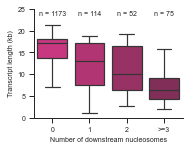

In [18]:
# Number of MCM DH vs observed rates
protein = 'NUC'
fig,axes = plt.subplots()

sns.boxplot(x='number_NUC',y='processivity',data=df_proc,order=sorted(df_proc['number_NUC'].unique()),
            palette=palettes[protein],fliersize=0)


#calculate number of observations
nobs = df_proc['number_NUC'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 24, nobs[tick],
    horizontalalignment='center',verticalalignment='center')

axes.set_ylim(0,25)
axes.set_xlabel('Number of downstream nucleosomes')
axes.set_ylabel('Transcript length (kb)')

# axes.set_title('T7 RNAP can push trains of MCM DHs')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S4F_Transcript_lengths_vs_#NUC.svg',transparent=True)

### Figure S4J: RNAP pushes individual nucleosomes to the DNA end
Note: only consider DNA w/o T7T, one NUC foci

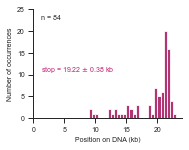

In [19]:
# version A: stop sites
protein = 'NUC'
# only consider molecules with 1 NUC foci being pushed
tag_filter = 'NUC_1_push'

_plot_df = (df[(df['number_NUC']==1) & (df['tags'].apply(
    lambda tags: True if re.search(tag_filter,' '.join(tags)) else False))].filter(regex=(protein+"_"),axis=1))

fig,axes = plt.subplots()

sns.distplot(_plot_df.xs('stop_site',level='properties',axis=1)/1000,ax=axes,
             color=sns.desaturate(palettes[protein][1],0.75),bins = np.linspace(0, 25, 51),kde=False,hist_kws={'alpha':1})

# mean+/- sem
mean_stop = pd.melt(_plot_df.xs('stop_site',level='properties',axis=1)/1000)['value'].mean()
sem_stop = pd.melt(_plot_df.xs('stop_site',level='properties',axis=1)/1000)['value'].sem()
axes.text(0.05, 0.5, f"stop = {round(mean_stop,2)} $\pm$ {round(sem_stop,2)} kb",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes,color=palettes[protein][1])

axes.set_xlim(0,24)
axes.set_ylim(0,25)
axes.set_xlabel('Position on DNA (kb)')
axes.set_ylabel('Number of occurrences')
#axes.legend(loc=0,frameon=False)

axes.text(0.05, 0.95, f"n = {len(_plot_df)}",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes)

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S4J_T7-NUC_pushed_distance_versionA.svg',transparent=True)

### Figure S4L: Collision outcome RNAP and Nucleosomes

In [20]:
# correlate collision outcome with NUC intensity
df_coll = pd.DataFrame(columns=['initial_intensity','coll_outcome'])

# loop through all archives with chromatin low (50x) and high (75x)
for archive in filter(lambda archive: archive.chromatin in {'50x','75x'},DnaMoleculeArchive.instances):
    for molecule in archive.molecules:
        # check for potential collision with each nucleosome
        intensity = 0
        for i in range(1,molecule.proteins['NUC']+1):
            collision = False
            for tag in molecule.tags:
                if re.match('coll_T7_1_NUC_'+str(i)+'_',tag):
                    collision = True
                    outcome = tag.split('coll_T7_1_NUC_'+str(i)+'_')[-1]
                    # exclude single outcome 'T7eject-NUCeject'
                    if outcome == 'T7eject-NUCeject':
                        collision = False
            if collision:
                # NUC intensity
                intensity += molecule.df.iloc[:5]['NUC_'+str(i)+'_Intensity'].mean()

                _temp_df = pd.DataFrame(data=[[intensity,outcome]],columns=['initial_intensity','coll_outcome'])
                df_coll = pd.concat([df_coll,_temp_df])

                # actions depending on different outcomes
                # reset intensity to 0 in case NUC was ejected and not pushed
                # note T7eject & stall won't lead to subsequent collisions

                # T7 ejected or stall => skip other nucleosomes
                if re.search('T7eject',outcome) or re.search('stall',outcome):
                    break
                # NUC ejected => go back to previous intensity
                elif re.search('NUCeject',outcome):
                    # subtract added intensity for subsequent collisions
                    intensity -= molecule.df.iloc[:5]['NUC_'+str(i)+'_Intensity'].mean()
                else:
                    # push and pause
                    continue
            

In [21]:
df_coll

,initial_intensity,coll_outcome
0,29289.1,stall
0,88198.0,pause
0,143430.9,stall
0,137454.6,push
0,40327.5,pause
...,...,...
0,48616.0,stall
0,52003.6,stall
0,84599.7,stall
0,41231.2,T7eject


In [22]:
df_coll['number_NUC'] = df_coll['initial_intensity'].apply(estimate_bleaching)
df_coll

,initial_intensity,coll_outcome,number_NUC
0,29289.1,stall,1
0,88198.0,pause,2
0,143430.9,stall,>=3
0,137454.6,push,2
0,40327.5,pause,1
...,...,...,...
0,48616.0,stall,1
0,52003.6,stall,1
0,84599.7,stall,2
0,41231.2,T7eject,1


In [23]:
df_coll.groupby('number_NUC').describe()

initial_intensity                                         \
                       count           mean           std       min   
number_NUC                                                            
1                      158.0   45618.546835  16489.987080    8618.9   
2                       60.0  105733.105000  17922.298709   80184.3   
>=3                     27.0  189346.107407  57258.102949  140153.0   

                                                        
                  25%        50%         75%       max  
number_NUC                                              
1            33467.90   43916.85   55870.775   79613.3  
2            90282.35  102457.10  121021.600  139356.4  
>=3         146549.80  175141.90  202412.950  363256.0

In [24]:
# concatenate nuc counts for both chromatin & valid dna counts
temp_df = pd.concat([pd.DataFrame(data=[df_coll[(df_coll['number_NUC']==number_nuc)]['coll_outcome'].value_counts()
                                        for number_nuc in df_coll['number_NUC'].unique()])],axis=0).T
temp_df.columns = [number_nuc for number_nuc in df_coll['number_NUC'].unique()]
temp_df

,1,2,>=3
push,82.0,28.0,8.0
stall,37.0,22.0,16.0
pause,16.0,7.0,NaN
T7eject,12.0,3.0,2.0
NUCeject,11.0,NaN,1.0


In [25]:
df_coll = temp_df.copy()
del(temp_df)

In [26]:
#order
df_coll = df_coll.reindex(['push', 'NUCeject','pause', 'stall', 'T7eject'])
df_coll

,1,2,>=3
push,82.0,28.0,8.0
NUCeject,11.0,NaN,1.0
pause,16.0,7.0,NaN
stall,37.0,22.0,16.0
T7eject,12.0,3.0,2.0


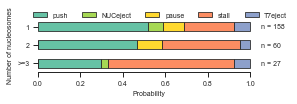

In [27]:
#plot a stacked barplot
fig,axes = plt.subplots(figsize=(4,1))

(df_coll.iloc[:, ::-1]/df_coll.iloc[:, ::-1].sum()).T.plot(kind='barh',stacked=True,ax=axes,rot=0,edgecolor='.15',
                               color=[palettes['qualitative'][0],palettes['qualitative'][4],
                                      palettes['qualitative'][5],palettes['qualitative'][1],
                                      palettes['qualitative'][2]])

axes.set_xlabel("Probability")
axes.set_ylabel("Number of nucleosomes")
#axes.set_title("Fate upon T7RNAP-MCM collision")
axes.set_xlim([0,1.05])


labels = [int(df_coll.iloc[:, ::-1].sum()[col]) for col in df_coll.iloc[:, ::-1].columns]

#calculate y offset to label bars on top

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    axes.text(1.05, rect.get_y() + rect.get_height()/2, s=f'n = {label}', ha='left', va='center')
    counter+=1
axes.legend(ncol=len(df.index),bbox_to_anchor=[-0.05, 1.05], loc='center left',frameon=False)

#tidy up
#fig.tight_layout()
sns.despine(trim=True,left=True)

#save
plt.savefig(dir_out+'S4L_T7-NUC_collision_fate.svg',transparent=True)

### Figure S4M: RNAP transcription rate vs #of pushed NUC

In [28]:
df_push = pd.DataFrame(columns=['initial_intensity','velocity'])

# loop through all archives with chromatin low (50x) and high (75x)
for archive in filter(lambda archive: archive.nucleotide == 'ATP',DnaMoleculeArchive.instances):
#for archive in [archive0,archive1,archive4,archive5]:
    # loop through all molecules
    for molecule in archive.molecules:
        valid = True
        
        for protein, number in molecule.proteins.items():
            # make sure molecule only contains NUC & T7 
            if (number > 0 and protein not in {'T7', 'NUC'}):
                valid = False
                continue
            # more than 1 T7 (just a sanity check, shouldn't happen)
            elif number > 1 and protein != 'NUC':
                valid = False
                continue
                
        # loop through all seg_dfs with T7 in prefix
        if valid:
            for seg_df in filter(lambda seg_df: 'T7' in seg_df.prefix, molecule.seg_dfs):
                # get the rate
                velocity = seg_df.calc_rate()[0]

                # get intensity_NUC
                intensity = 0
                # add intensities for all pushed NUCs
                for i in range(1,seg_df.pushed_proteins['NUC']+1):
                    intensity += molecule.df.iloc[:5]['NUC_'+str(i)+'_Intensity'].mean()

                _temp_df = pd.DataFrame(data=[[intensity,velocity]],
                                        columns=['initial_intensity','velocity'])
                df_push = pd.concat([df_push,_temp_df])
                
                
df_push = df_push.convert_dtypes()
df_push = df_push.dropna()
df_push

,initial_intensity,velocity
0,0.0,58.722497
0,0.0,67.159358
0,137454.6,58.841586
0,0.0,55.365914
0,0.0,61.796567
...,...,...
0,0.0,58.251796
0,0.0,59.341375
0,0.0,58.296173
0,0.0,60.552408


In [29]:
df_push.corr()

,initial_intensity,velocity
initial_intensity,1.000000,-0.265296
velocity,-0.265296,1.000000


In [30]:
df_push['number_NUC'] = df_push['initial_intensity'].apply(estimate_bleaching)

In [31]:
df_push.groupby('number_NUC').describe()

initial_intensity                                         \
                       count           mean           std       min   
number_NUC                                                            
0                     1756.0       0.000000      0.000000       0.0   
1                       84.0   43091.905952  15384.843099   13533.4   
2                       30.0  103480.076667  17317.441732   80184.3   
>=3                      8.0  180499.050000  37597.208207  143875.6   

                                                        velocity             \
                   25%        50%         75%       max    count       mean   
number_NUC                                                                    
0                0.000       0.00       0.000       0.0   1756.0  56.850575   
1            32033.325   40461.35   52215.600   79518.4     84.0  49.738283   
2            91102.675  100888.45  116560.975  137454.6     30.0  48.091939   
>=3         146977.925  175768.90  196938.675  247682.6      8.0  39.124912   

                                                                              
                  std        min        25%        50%        75%        max  
number_NUC                                                                    
0            6.275875   6.945447  54.391048  57.647142  60.299595  84.736766  
1           15.681517  10.694009  40.115195  54.822266  62.095470  78.164749  
2           16.107670   7.913715  38.905308  56.735983  58.816728  64.636143  
>=3         15.948537  17.487548  27.028458  35.866888  53.381757  62.264861

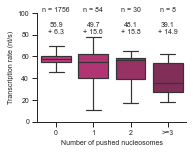

In [32]:
# Number of NUC vs observed rates
protein = 'NUC'
fig,axes = plt.subplots()

sns.boxplot(x='number_NUC',y='velocity',data=df_push,order=sorted(df_push['number_NUC'].unique()),
            palette=palettes[protein],fliersize=0)


#calculate number of observations
nobs = df_push['number_NUC'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 100, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom')
    
rates = []
# fit data to normal distribution and print on plot
for num_nuc in sorted(df_push['number_NUC'].unique()):
    mu, std = norm.fit(df_push[df_push['number_NUC']==num_nuc]['velocity'])
    rates.append(f'{round(mu,1)}\n+ {round(std,1)}')
    
for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 80, rates[tick],
    horizontalalignment='center',verticalalignment='bottom')

axes.set_ylim(0,100)
axes.set_xlabel('Number of pushed nucleosomes')
axes.set_ylabel('Transcription rate (nt/s)')

# axes.set_title('T7 RNAP can push trains of MCM DHs')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S4M_Transcription_rates_vs_#NUC.svg',transparent=True)